In [1]:
%matplotlib inline

In [2]:
import torch
import numpy as np
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, models, transforms
from torchvision.transforms import ToTensor, Resize, Compose

## Training components

<img src="./components.png" width="80%">

## Prepare the dataset

In [3]:
import os
from PIL import Image

class CustomImageDataset(Dataset):
    def __init__(self, img_dir, transform=None, target_transform=None):  
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        # load the files 
        filenames = []
        labels = []
        for filename in os.listdir(img_dir):
            filenames.append(filename)
            if filename.startswith("bird"):
                labels.append(0)
            elif filename.startswith("cat"):
                labels.append(1)
            elif filename.startswith("dog"):
                labels.append(2)
        self.filenames = filenames
        self.labels = labels

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.filenames[idx])
        image = Image.open(img_path)
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [4]:
pet_dataset = CustomImageDataset("./data/pets",transform = Compose([ToTensor(), Resize((28,28))]))
train_size = int(0.8 * len(pet_dataset))
test_size = len(pet_dataset) - train_size

train_dataset, test_dataset = torch.utils.data.random_split(pet_dataset, [train_size, test_size])

train_dataloader = DataLoader(train_dataset, batch_size=6, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=6, shuffle=True)

## Creating Models
Here we try two different neural networks: 
- Simple model with some convolutional layers;
- A pretrained classical convolutional neural network architecture: ResNet18.

In [5]:

# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

    
# Define model
class ConvNN(nn.Module):
    def __init__(self):
        super(ConvNN, self).__init__()
        self.conv_stack = nn.Sequential(
            nn.Conv2d(3,6,5),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(6,12,5),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten(),
            nn.ReLU(),
            nn.Linear(192, 512),
            nn.ReLU(),
            nn.Linear(512, 3)
        )

    def forward(self, x):
        logits = self.conv_stack(x)
        return logits
    

conv_model = ConvNN().to(device)
print(conv_model)

Using cpu device
ConvNN(
  (conv_stack): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 12, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): ReLU()
    (8): Linear(in_features=192, out_features=512, bias=True)
    (9): ReLU()
    (10): Linear(in_features=512, out_features=3, bias=True)
  )
)


All pre-trained models expect input images normalized in the same way, i.e. mini-batches of 3-channel RGB images of shape (3 x H x W), where H and W are expected to be at least 224. The images have to be loaded in to a range of [0, 1] and then normalized using mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225].

In [ ]:
# Define model, dataset and dataloader for vgg model
    
resnet_model = models.resnet18(pretrained=True).to(device)
resnet_model

In [ ]:
resnet_transform = Compose([ToTensor(), Resize((224,224)), transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])])

pet_dataset_resnet = CustomImageDataset("./data/pets",transform = resnet_transform)
train_size = int(0.8 * len(pet_dataset_resnet))
test_size = len(pet_dataset_resnet) - train_size

train_dataset_resnet, test_dataset_resnet = torch.utils.data.random_split(pet_dataset_resnet, [train_size, test_size])

train_dataloader_resnet = DataLoader(train_dataset_resnet, batch_size=6, shuffle=True)
test_dataloader_resnet = DataLoader(test_dataset_resnet, batch_size=6, shuffle=True)

In [8]:
num_ftrs = resnet_model.fc.in_features
resnet_model.fc = nn.Linear(num_ftrs, 3)
resnet_model = resnet_model.to(device)

## Optimizing the Model Parameters

To train a model, we need a `loss function` and an `optimizer`.

In [9]:

model = conv_model #resnet_model
trainloader = train_dataloader #train_dataloader_resnet
testloader = test_dataloader #test_dataloader_resnet
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=1e-4)

In a single training loop, the model makes predictions on the training dataset (fed to it in batches), and
backpropagates the prediction error to adjust the model's parameters.



In [10]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.train()
    correct, train_loss = 0, 0 
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)
        train_loss += loss.item()
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    correct /= size
    train_loss /= num_batches
    return train_loss, correct

We also check the model's performance against the test dataset to ensure it is learning.



In [11]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    return test_loss, correct



The training process is conducted over several iterations (*epochs*). During each epoch, the model learns
parameters to make better predictions. We print the model's accuracy and loss at each epoch; we'd like to see the
accuracy increase and the loss decrease with every epoch.



In [12]:
epochs = 500
for t in range(epochs):
    train_loss, train_acc = train(trainloader, model, loss_fn, optimizer)
    test_loss, test_acc = test(testloader, model, loss_fn)
    if t%1 == 0:
        print(f"Epoch {t}:")
        print(f"Train Error. Accuracy: {(100*train_acc):>0.1f}%, Avg loss: {train_loss:>8f}")
        print(f"Test Error. Accuracy: {(100*test_acc):>0.1f}%, Avg loss: {test_loss:>8f}")
print("Done!")

Epoch 0:
Train Error. Accuracy: 25.0%, Avg loss: 1.105933
Test Error. Accuracy: 25.0%, Avg loss: 1.100908
Epoch 1:
Train Error. Accuracy: 33.3%, Avg loss: 1.095631
Test Error. Accuracy: 25.0%, Avg loss: 1.103517
Epoch 2:
Train Error. Accuracy: 44.8%, Avg loss: 1.089751
Test Error. Accuracy: 25.0%, Avg loss: 1.105336
Epoch 3:
Train Error. Accuracy: 43.8%, Avg loss: 1.085642
Test Error. Accuracy: 25.0%, Avg loss: 1.106987
Epoch 4:
Train Error. Accuracy: 40.6%, Avg loss: 1.081579
Test Error. Accuracy: 29.2%, Avg loss: 1.108339
Epoch 5:
Train Error. Accuracy: 46.9%, Avg loss: 1.077004
Test Error. Accuracy: 29.2%, Avg loss: 1.105930
Epoch 6:
Train Error. Accuracy: 53.1%, Avg loss: 1.069416
Test Error. Accuracy: 29.2%, Avg loss: 1.109125
Epoch 7:
Train Error. Accuracy: 49.0%, Avg loss: 1.064280
Test Error. Accuracy: 29.2%, Avg loss: 1.109840
Epoch 8:
Train Error. Accuracy: 54.2%, Avg loss: 1.060263
Test Error. Accuracy: 29.2%, Avg loss: 1.108815
Epoch 9:
Train Error. Accuracy: 55.2%, Avg los

Epoch 77:
Train Error. Accuracy: 80.2%, Avg loss: 0.554103
Test Error. Accuracy: 41.7%, Avg loss: 1.281196
Epoch 78:
Train Error. Accuracy: 82.3%, Avg loss: 0.536387
Test Error. Accuracy: 45.8%, Avg loss: 1.263702
Epoch 79:
Train Error. Accuracy: 83.3%, Avg loss: 0.536547
Test Error. Accuracy: 41.7%, Avg loss: 1.300667
Epoch 80:
Train Error. Accuracy: 80.2%, Avg loss: 0.516795
Test Error. Accuracy: 41.7%, Avg loss: 1.252316
Epoch 81:
Train Error. Accuracy: 81.2%, Avg loss: 0.513404
Test Error. Accuracy: 41.7%, Avg loss: 1.282304
Epoch 82:
Train Error. Accuracy: 84.4%, Avg loss: 0.517409
Test Error. Accuracy: 50.0%, Avg loss: 1.282447
Epoch 83:
Train Error. Accuracy: 84.4%, Avg loss: 0.503357
Test Error. Accuracy: 45.8%, Avg loss: 1.282236
Epoch 84:
Train Error. Accuracy: 83.3%, Avg loss: 0.503704
Test Error. Accuracy: 45.8%, Avg loss: 1.317953
Epoch 85:
Train Error. Accuracy: 84.4%, Avg loss: 0.492420
Test Error. Accuracy: 45.8%, Avg loss: 1.329925
Epoch 86:
Train Error. Accuracy: 84.4

Epoch 154:
Train Error. Accuracy: 96.9%, Avg loss: 0.164163
Test Error. Accuracy: 41.7%, Avg loss: 1.675167
Epoch 155:
Train Error. Accuracy: 97.9%, Avg loss: 0.159460
Test Error. Accuracy: 41.7%, Avg loss: 1.664824
Epoch 156:
Train Error. Accuracy: 96.9%, Avg loss: 0.162101
Test Error. Accuracy: 37.5%, Avg loss: 1.783575
Epoch 157:
Train Error. Accuracy: 99.0%, Avg loss: 0.164815
Test Error. Accuracy: 33.3%, Avg loss: 1.750986
Epoch 158:
Train Error. Accuracy: 97.9%, Avg loss: 0.154956
Test Error. Accuracy: 41.7%, Avg loss: 1.692951
Epoch 159:
Train Error. Accuracy: 96.9%, Avg loss: 0.146655
Test Error. Accuracy: 41.7%, Avg loss: 1.692876
Epoch 160:
Train Error. Accuracy: 96.9%, Avg loss: 0.148188
Test Error. Accuracy: 45.8%, Avg loss: 1.672458
Epoch 161:
Train Error. Accuracy: 99.0%, Avg loss: 0.143393
Test Error. Accuracy: 41.7%, Avg loss: 1.717808
Epoch 162:
Train Error. Accuracy: 97.9%, Avg loss: 0.136550
Test Error. Accuracy: 33.3%, Avg loss: 1.753252
Epoch 163:
Train Error. Accu

Epoch 231:
Train Error. Accuracy: 100.0%, Avg loss: 0.018196
Test Error. Accuracy: 33.3%, Avg loss: 2.641803
Epoch 232:
Train Error. Accuracy: 100.0%, Avg loss: 0.017331
Test Error. Accuracy: 33.3%, Avg loss: 2.582315
Epoch 233:
Train Error. Accuracy: 100.0%, Avg loss: 0.016807
Test Error. Accuracy: 41.7%, Avg loss: 2.584631
Epoch 234:
Train Error. Accuracy: 100.0%, Avg loss: 0.017305
Test Error. Accuracy: 41.7%, Avg loss: 2.596269
Epoch 235:
Train Error. Accuracy: 100.0%, Avg loss: 0.017208
Test Error. Accuracy: 33.3%, Avg loss: 2.568711
Epoch 236:
Train Error. Accuracy: 100.0%, Avg loss: 0.014683
Test Error. Accuracy: 37.5%, Avg loss: 2.753527
Epoch 237:
Train Error. Accuracy: 100.0%, Avg loss: 0.014130
Test Error. Accuracy: 33.3%, Avg loss: 2.755240
Epoch 238:
Train Error. Accuracy: 100.0%, Avg loss: 0.014348
Test Error. Accuracy: 33.3%, Avg loss: 2.811040
Epoch 239:
Train Error. Accuracy: 100.0%, Avg loss: 0.013737
Test Error. Accuracy: 41.7%, Avg loss: 2.651724
Epoch 240:
Train Er

Epoch 307:
Train Error. Accuracy: 100.0%, Avg loss: 0.000989
Test Error. Accuracy: 33.3%, Avg loss: 3.744904
Epoch 308:
Train Error. Accuracy: 100.0%, Avg loss: 0.000988
Test Error. Accuracy: 33.3%, Avg loss: 3.670956
Epoch 309:
Train Error. Accuracy: 100.0%, Avg loss: 0.000975
Test Error. Accuracy: 33.3%, Avg loss: 3.808201
Epoch 310:
Train Error. Accuracy: 100.0%, Avg loss: 0.000902
Test Error. Accuracy: 33.3%, Avg loss: 3.710886
Epoch 311:
Train Error. Accuracy: 100.0%, Avg loss: 0.000854
Test Error. Accuracy: 33.3%, Avg loss: 3.747699
Epoch 312:
Train Error. Accuracy: 100.0%, Avg loss: 0.000917
Test Error. Accuracy: 33.3%, Avg loss: 3.726848
Epoch 313:
Train Error. Accuracy: 100.0%, Avg loss: 0.000842
Test Error. Accuracy: 33.3%, Avg loss: 3.799012
Epoch 314:
Train Error. Accuracy: 100.0%, Avg loss: 0.000837
Test Error. Accuracy: 33.3%, Avg loss: 3.861805
Epoch 315:
Train Error. Accuracy: 100.0%, Avg loss: 0.000773
Test Error. Accuracy: 33.3%, Avg loss: 3.813013
Epoch 316:
Train Er

Epoch 383:
Train Error. Accuracy: 100.0%, Avg loss: 0.000103
Test Error. Accuracy: 33.3%, Avg loss: 4.623977
Epoch 384:
Train Error. Accuracy: 100.0%, Avg loss: 0.000098
Test Error. Accuracy: 33.3%, Avg loss: 4.721082
Epoch 385:
Train Error. Accuracy: 100.0%, Avg loss: 0.000098
Test Error. Accuracy: 33.3%, Avg loss: 4.550752
Epoch 386:
Train Error. Accuracy: 100.0%, Avg loss: 0.000096
Test Error. Accuracy: 33.3%, Avg loss: 4.635726
Epoch 387:
Train Error. Accuracy: 100.0%, Avg loss: 0.000090
Test Error. Accuracy: 33.3%, Avg loss: 4.808223
Epoch 388:
Train Error. Accuracy: 100.0%, Avg loss: 0.000092
Test Error. Accuracy: 33.3%, Avg loss: 4.673101
Epoch 389:
Train Error. Accuracy: 100.0%, Avg loss: 0.000090
Test Error. Accuracy: 33.3%, Avg loss: 4.734736
Epoch 390:
Train Error. Accuracy: 100.0%, Avg loss: 0.000091
Test Error. Accuracy: 33.3%, Avg loss: 4.707473
Epoch 391:
Train Error. Accuracy: 100.0%, Avg loss: 0.000088
Test Error. Accuracy: 33.3%, Avg loss: 4.697787
Epoch 392:
Train Er

Epoch 459:
Train Error. Accuracy: 100.0%, Avg loss: 0.000016
Test Error. Accuracy: 37.5%, Avg loss: 5.527681
Epoch 460:
Train Error. Accuracy: 100.0%, Avg loss: 0.000015
Test Error. Accuracy: 37.5%, Avg loss: 5.533540
Epoch 461:
Train Error. Accuracy: 100.0%, Avg loss: 0.000015
Test Error. Accuracy: 37.5%, Avg loss: 5.539848
Epoch 462:
Train Error. Accuracy: 100.0%, Avg loss: 0.000015
Test Error. Accuracy: 37.5%, Avg loss: 5.546996
Epoch 463:
Train Error. Accuracy: 100.0%, Avg loss: 0.000014
Test Error. Accuracy: 37.5%, Avg loss: 5.545717
Epoch 464:
Train Error. Accuracy: 100.0%, Avg loss: 0.000014
Test Error. Accuracy: 37.5%, Avg loss: 5.552591
Epoch 465:
Train Error. Accuracy: 100.0%, Avg loss: 0.000013
Test Error. Accuracy: 37.5%, Avg loss: 5.555076
Epoch 466:
Train Error. Accuracy: 100.0%, Avg loss: 0.000013
Test Error. Accuracy: 37.5%, Avg loss: 5.561263
Epoch 467:
Train Error. Accuracy: 100.0%, Avg loss: 0.000013
Test Error. Accuracy: 37.5%, Avg loss: 5.561089
Epoch 468:
Train Er

This model can now be used to make predictions.



accuracy: 1/6.


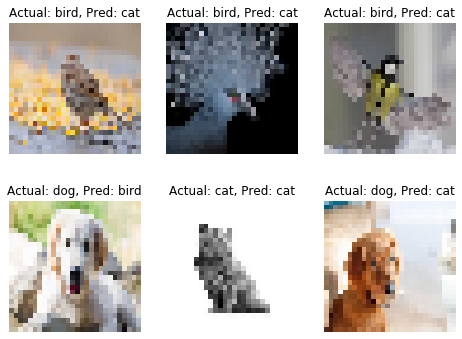

In [13]:
import matplotlib.pyplot as plt 
from torchvision.transforms import ToPILImage


classes = ["bird", "cat", "dog"]
model.eval()
x, labels = next(iter(testloader))

figure = plt.figure(figsize=(8, 6))
cols, rows = 3, 2
with torch.no_grad():
    preds = model(x)
correct = 0
for i in range(len(preds)):
    predicted, actual = classes[preds[i].argmax()], classes[labels[i]]
    if predicted == actual:
        correct += 1
    img = x[i]
    """
    mean = torch.tensor([0.485, 0.456, 0.406]).reshape((3,1,1))
    std = torch.tensor([0.229, 0.224, 0.225]).reshape((3,1,1))
    img = std * img + mean"""
    
    figure.add_subplot(rows, cols, i + 1)
    plt.title(f"Actual: {actual}, Pred: {predicted}")
    plt.axis("off")
    plt.imshow(ToPILImage()(img))
print(f"accuracy: %i/%i."% ( correct,  len(preds)))

Saving Models
-------------
A common way to save a model is to serialize the internal state dictionary (containing the model parameters).



In [14]:
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


Loading Models
----------------------------

The process for loading a model includes re-creating the model structure and loading
the state dictionary into it.



In [15]:
model.load_state_dict(torch.load("model.pth"))

<All keys matched successfully>